# このノートブックについて

このノートブックは、あらかじめ起動しておいたDelta Sharingを通じ、データレイク上のデータを読み取り、Apache Sparkで簡単な分析を実行してみる例である。

今回は、簡単な動作確認であるため以下のような構成を前提とする。

![簡単な動作確認のための構成例](https://github.com/dobachi/PythonKafkaECHONETLiteExample/blob/main/images/ArchitectureProcessingDataViaDeltaSharing.png?raw=true)

なお、手元の環境ではDelta Sharingが共有するデータを保持するバックエンドのストレージとしてAWS S3やMinIOを用いて動作確認した。

# テーブルの確認

センサーのダミーデータ2種類、パワーグリッドのダミーデータ1種類をDelta Sharing経由で読み込む。

なお、これらのダミーデータは [GenerateRandomSensorData.ipynb] や [GenerateDummyPowerGridData.ipynb] を用いて生成した。

[GenerateRandomSensorData.ipynb]: https://github.com/dobachi/PythonKafkaECHONETLiteExample/blob/main/GenerateRandomSensorData.ipynb
[GenerateDummyPowerGridData.ipynb]: https://github.com/dobachi/PythonKafkaECHONETLiteExample/blob/main/GenerateDummyPowerGridData.ipynb

In [1]:
import delta_sharing
from pyspark.sql import Row
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType
from struct import *
from datetime import datetime
import matplotlib as plt
import matplotlib.pyplot as pyplt
import numpy as np
import pandas as pd
from sktime.forecasting.arima import AutoARIMA #ARIMAモデル
from sktime.forecasting.exp_smoothing import ExponentialSmoothing #ESモデル
from sktime.forecasting.ets import AutoETS #ETSモデル
from sktime.forecasting.tbats import TBATS #TBATSモデル
from sktime.forecasting.compose import EnsembleForecaster #アンサンブル
from sktime.utils.plotting import plot_series #グラフ化
from sktime.forecasting.model_selection import temporal_train_test_split


ひとまず、読み込む3データのクライアント用プロファイルを定義。
今回は簡単な例として、本プロジェクトの `./conf` 以下に設定ファイル例を置いた。

設定ファイルは例えば

```
{
  "shareCredentialsVersion": 1,
  "endpoint": "http://localhost:8083/power_grid",
  "bearerToken": ""
}
```

のような構成であり、今回は同一マシン or インスタンス上にDelta Sharingサーバを起動した例になっている。
もし別に起動している場合は、設定ファイルを編集すること。

In [2]:
profile_file_01 = 'conf/sensor_data_01.share'
profile_file_02 = 'conf/sensor_data_02.share'
profile_file_power = 'conf/power_grid.share'

テーブル情報を軽く確認する。

In [3]:
client01 = delta_sharing.SharingClient(profile_file_01)
client02 = delta_sharing.SharingClient(profile_file_02)
client_power = delta_sharing.SharingClient(profile_file_power)

In [4]:
client01.list_all_tables()

[Table(name='table', share='sensor_data_01', schema='schema')]

In [5]:
client02.list_all_tables()

[Table(name='table', share='sensor_data_02', schema='schema')]

In [6]:
client_power.list_all_tables()

[Table(name='table', share='power_grid_dummydata', schema='schema')]

# Sparkで読み込む

テーブルは問題なさそうなので、データを読み込む。

以下の通り、実際に格納されたテーブルを指定する。

In [7]:
table01_url = profile_file_01 + '#sensor_data_01.schema.table'
table02_url = profile_file_02 + '#sensor_data_02.schema.table'
table_power_url = profile_file_power + '#power_grid_dummydata.schema.table'

PandasのDataFrameとして読み込むAPIもあるが、今回はApache SparkのDataFrameとして読み込むことにする。

最初はエアコンから読み込んだ電源情報と温度設定値の（ダミーデータの）テーブルを読み込む。

In [8]:
sdf01 = delta_sharing.load_as_spark(table01_url)
sdf01.show()

+-------------------+------------+-----+
|          timestamp|          id|state|
+-------------------+------------+-----+
|2021-01-06 00:00:00|0038#0x0,0x1|49,24|
|2021-01-06 00:00:00|0039#0x0,0x1|48,23|
|2021-01-06 00:00:00|0051#0x0,0x1|48,26|
|2021-01-06 00:00:00|0056#0x0,0x1|49,20|
|2021-01-06 00:00:00|0061#0x0,0x1|49,26|
|2021-01-06 00:00:00|0067#0x0,0x1|48,25|
|2021-01-06 00:00:00|0092#0x0,0x1|48,22|
|2021-01-06 00:00:00|0175#0x0,0x1|49,24|
|2021-01-06 00:00:00|0181#0x0,0x1|49,24|
|2021-01-06 00:00:00|0186#0x0,0x1|49,24|
|2021-01-06 00:00:00|0198#0x0,0x1|49,28|
|2021-01-06 00:00:00|0272#0x0,0x1|48,28|
|2021-01-06 00:00:00|0275#0x0,0x1|48,29|
|2021-01-06 00:00:00|0285#0x0,0x1|48,24|
|2021-01-06 00:00:00|0289#0x0,0x1|48,29|
|2021-01-06 00:00:00|0291#0x0,0x1|48,27|
|2021-01-06 00:00:00|0301#0x0,0x1|48,25|
|2021-01-06 00:00:00|0338#0x0,0x1|48,26|
|2021-01-06 00:00:00|0352#0x0,0x1|48,22|
|2021-01-06 00:00:00|0366#0x0,0x1|48,27|
+-------------------+------------+-----+
only showing top

In [9]:
sdf02 = delta_sharing.load_as_spark(table02_url)
sdf02.show()

+-------------------+------------+-----+
|          timestamp|          id|state|
+-------------------+------------+-----+
|2021-01-06 00:00:00|1024#0x0,0x1|49,23|
|2021-01-06 00:00:00|1030#0x0,0x1|48,21|
|2021-01-06 00:00:00|1041#0x0,0x1|48,25|
|2021-01-06 00:00:00|1046#0x0,0x1|48,27|
|2021-01-06 00:00:00|1071#0x0,0x1|48,22|
|2021-01-06 00:00:00|1094#0x0,0x1|48,24|
|2021-01-06 00:00:00|1102#0x0,0x1|48,23|
|2021-01-06 00:00:00|1105#0x0,0x1|48,23|
|2021-01-06 00:00:00|1124#0x0,0x1|49,28|
|2021-01-06 00:00:00|1134#0x0,0x1|48,26|
|2021-01-06 00:00:00|1148#0x0,0x1|48,25|
|2021-01-06 00:00:00|1164#0x0,0x1|49,25|
|2021-01-06 00:00:00|1166#0x0,0x1|48,26|
|2021-01-06 00:00:00|1185#0x0,0x1|48,27|
|2021-01-06 00:00:00|1189#0x0,0x1|48,27|
|2021-01-06 00:00:00|1208#0x0,0x1|48,21|
|2021-01-06 00:00:00|1250#0x0,0x1|48,23|
|2021-01-06 00:00:00|1252#0x0,0x1|48,25|
|2021-01-06 00:00:00|1265#0x0,0x1|49,25|
|2021-01-06 00:00:00|1269#0x0,0x1|49,27|
+-------------------+------------+-----+
only showing top

データ取得（正確には、Apache Kafkaクラスタへの書き込み）時刻、デバイスのID、状態情報を表すテキストが格納されていることがわかる。
今回はダミーデータなので値そのものには意味はなく、IDや状態情報もランダム値である。
状態情報は、仮でテキストデータとして書き込まれていることにした。

続いて、電力需給データ（のダミーデータ）を読み込む。


In [10]:
sdf_power = delta_sharing.load_as_spark(table_power_url)
sdf_power.show()

+-------------------+--------+---------+------------------+-----------------------+
|          timestamp|Measured|Predicted|           UseRate|EstimatedSupplyCapacity|
+-------------------+--------+---------+------------------+-----------------------+
|2021-01-05 00:00:00|    1531|     1490|0.8302603036876356|                   1844|
|2021-01-05 00:01:00|    1489|     1490|0.8074837310195228|                   1844|
|2021-01-05 00:02:00|    1483|     1490|0.8042299349240781|                   1844|
|2021-01-05 00:03:00|    1522|     1490|0.8253796095444685|                   1844|
|2021-01-05 00:04:00|    1491|     1490|0.8085683297180043|                   1844|
|2021-01-05 00:05:00|    1515|     1490| 0.821583514099783|                   1844|
|2021-01-05 00:06:00|    1511|     1490|  0.81941431670282|                   1844|
|2021-01-05 00:07:00|    1495|     1490|0.8107375271149675|                   1844|
|2021-01-05 00:08:00|    1489|     1490|0.8074837310195228|                 

ここではMeasured：計測された電力需要値、Predicted：予測された電力需要値、UseRate：Measured/EstimatedSupplyCapacity、EstimatedSupplyCapacity：推測された電力供給キャパシティとして、それっぽいランダムな値を生成して用いた。

以上で、3種類のデータを読めた。

# データを軽く確認する（単純な集計をしてみる）

ひとまず推定キャパシティに対して、使用量が高くなっている瞬間を確認するため、 `UseRate` が97.8%（0.97）を超えた瞬間を確認する。
PySparkを用いているので、もし大量のデータがあってもスケールアウトして計算可能。

In [11]:
sdf_power_01 = sdf_power.filter(col('UseRate') > 0.97)

In [12]:
sdf_power_01.show()

+-------------------+--------+---------+------------------+-----------------------+
|          timestamp|Measured|Predicted|           UseRate|EstimatedSupplyCapacity|
+-------------------+--------+---------+------------------+-----------------------+
|2021-01-05 09:00:00|    2263|     2147|0.9716616573636754|                   2329|
|2021-01-05 09:08:00|    2265|     2147|0.9725203950193216|                   2329|
|2021-01-05 09:14:00|    2268|     2147|0.9738085015027909|                   2329|
|2021-01-05 09:21:00|    2265|     2147|0.9725203950193216|                   2329|
|2021-01-05 09:24:00|    2268|     2147|0.9738085015027909|                   2329|
|2021-01-05 09:26:00|    2267|     2147|0.9733791326749678|                   2329|
|2021-01-05 09:31:00|    2267|     2147|0.9733791326749678|                   2329|
|2021-01-05 09:35:00|    2262|     2147|0.9712322885358523|                   2329|
|2021-01-05 09:50:00|    2262|     2147|0.9712322885358523|                 

これを見ると、11時台に入ってからしばらく97%を超えていることがわかる。
ここで、試しに11時台に電源が入っており、温度設定が高かったデバイスを確認してみる。

まずは、2種類のデータ（今回の例では、出元が2種類ある、という気持ちで準備した）をくっつける。

In [13]:
sdf_all = sdf01.union(sdf02)

状態の入っていた文字列を分解し、電源状態と温度設定の2個の値に変換する処理（UDF）を定義する。
PySpark側に任意の関数を渡せる。

In [14]:
@udf(ArrayType(IntegerType()))
def transform_state(state_str):
    p_state, temperature = state_str.split(',')
    return int(p_state), int(temperature)

定義したUDFを利用して変換する。

In [15]:
sdf_all_01 = sdf_all.withColumn('state2', transform_state(col('state'))).\
    select('timestamp', 'id', col('state2')[0].alias('p_state'), col('state2')[1].alias('temperature'))

In [16]:
sdf_all_01.show()

+-------------------+------------+-------+-----------+
|          timestamp|          id|p_state|temperature|
+-------------------+------------+-------+-----------+
|2021-01-06 00:00:00|0038#0x0,0x1|     49|         24|
|2021-01-06 00:00:00|0039#0x0,0x1|     48|         23|
|2021-01-06 00:00:00|0051#0x0,0x1|     48|         26|
|2021-01-06 00:00:00|0056#0x0,0x1|     49|         20|
|2021-01-06 00:00:00|0061#0x0,0x1|     49|         26|
|2021-01-06 00:00:00|0067#0x0,0x1|     48|         25|
|2021-01-06 00:00:00|0092#0x0,0x1|     48|         22|
|2021-01-06 00:00:00|0175#0x0,0x1|     49|         24|
|2021-01-06 00:00:00|0181#0x0,0x1|     49|         24|
|2021-01-06 00:00:00|0186#0x0,0x1|     49|         24|
|2021-01-06 00:00:00|0198#0x0,0x1|     49|         28|
|2021-01-06 00:00:00|0272#0x0,0x1|     48|         28|
|2021-01-06 00:00:00|0275#0x0,0x1|     48|         29|
|2021-01-06 00:00:00|0285#0x0,0x1|     48|         24|
|2021-01-06 00:00:00|0289#0x0,0x1|     48|         29|
|2021-01-0

11時台のデータを残す（フィルタする）

In [28]:
sdf_all_02 = sdf_all_01.filter((col('timestamp') >= datetime.strptime('2021-01-06 11:00:00', '%Y-%m-%d %H:%M:%S')) &
                              (col('timestamp') < datetime.strptime('2021-01-06 12:00:00', '%Y-%m-%d %H:%M:%S')))

電源がONで、28度より高い温度設定のデバイスを探す。

In [18]:
sdf_all_03 = sdf_all_02.filter((col('temperature') > 28) & (col('p_state') == 48)).select('id').distinct()

In [19]:
sdf_all_03.show()

+------------+
|          id|
+------------+
|0840#0x0,0x1|
|0902#0x0,0x1|
|0198#0x0,0x1|
|0352#0x0,0x1|
|0092#0x0,0x1|
|0285#0x0,0x1|
|0652#0x0,0x1|
|1030#0x0,0x1|
|0468#0x0,0x1|
|1335#0x0,0x1|
|1148#0x0,0x1|
|1124#0x0,0x1|
|0813#0x0,0x1|
|1024#0x0,0x1|
+------------+



以上のデバイスの温度設定が高かったことがわかる。

# 時系列データから予測値算出

デバイスの状態情報は時系列データとして扱えるので、時系列データ分析ライブラリを利用し、温度設定値の予測を簡単にやってみる。

ここでは、デバイスごとにグルーピングした時系列データをPandas DataFrameとして扱い、それぞれ分析することにする。

まずは、Pandas UDFを定義する。

In [20]:
result_schema = StructType(
                [
                StructField('id', StringType()),
                StructField('timestamp', TimestampType()),
                StructField('temperature_forecast', DoubleType())
                ])

In [21]:
def forecast_temp(device_pd):
    forecaster = AutoARIMA(sp=12, suppress_warnings=True)
    device_pd['period'] = pd.DatetimeIndex(device_pd['timestamp']).to_period('T')
    device_pd01 = device_pd.set_index('period')
    device_s = device_pd01['temperature']
    device_s01 = device_s.rolling(20).mean()  # ダミーデータはランダムに散らしてあるので、いったん平均値を求める
    device_s02 = device_s01.dropna(how='all')  # 平均値求めるときにNaNになった部分を削除する
    forecaster.fit(device_s02)
    fh = np.arange(60)
    pred = forecaster.predict(fh)
    pred.name = 'temperature_forecast'
    pred_df = pd.DataFrame(pred)
    #print(device_pd[20:]['id'])
    pred_df['id'] = device_pd.at[0, 'id']
    pred_df['timestamp'] = pred_df.index.to_timestamp()
    #print(pred_df)

    return pd.DataFrame(pred_df)

定義したUDFを利用し、デバイスごとの温度設定の推測を求める。

In [22]:
# ここでは処理の省略のため、`filter`を利用しているが本来はfilter不要
# sdf_forecast = sdf_all_01.groupBy('id').applyInPandas(forecast_temp, schema='id string, timestamp timestamp, temperature_forecast double')

sdf_forecast = sdf_all_01.filter(col('id') == '0301#0x0,0x1')\
    .groupBy('id')\
    .applyInPandas(forecast_temp, schema='id string, timestamp timestamp, temperature_forecast double')

In [23]:
sdf_forecast.show()

/home/dobachi/Sources/PythonKafkaECHONETLiteExample/venv/lib/python3.7/site-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


+------------+-------------------+--------------------+
|          id|          timestamp|temperature_forecast|
+------------+-------------------+--------------------+
|0301#0x0,0x1|2021-01-06 23:59:00|  28.994225533421535|
|0301#0x0,0x1|2021-01-07 00:00:00|  28.994225533421535|
|0301#0x0,0x1|2021-01-07 00:01:00|   28.98296805565188|
|0301#0x0,0x1|2021-01-07 00:02:00|   28.96651685561732|
|0301#0x0,0x1|2021-01-07 00:03:00|  28.945158531985992|
|0301#0x0,0x1|2021-01-07 00:04:00|   28.91917650051477|
|0301#0x0,0x1|2021-01-07 00:05:00|  28.888850532106073|
|0301#0x0,0x1|2021-01-07 00:06:00|  28.854456321094816|
|0301#0x0,0x1|2021-01-07 00:07:00|  28.816265083243188|
|0301#0x0,0x1|2021-01-07 00:08:00|  28.774543182881672|
|0301#0x0,0x1|2021-01-07 00:09:00|  28.729551788598446|
|0301#0x0,0x1|2021-01-07 00:10:00|   28.68154655684631|
|0301#0x0,0x1|2021-01-07 00:11:00|  28.630777342805917|
|0301#0x0,0x1|2021-01-07 00:12:00|  28.577487937817008|
|0301#0x0,0x1|2021-01-07 00:13:00|   28.52191583

上記のように、予測が得られた。
試しに、1デバイス分のデータを取り出し、可視化してみる。

In [24]:
# 事前に `filter` している場合は不要だが、今回はもともと `filter` していなかったものとして扱う

pdf_forecast = sdf_forecast.filter(col('id') == '0301#0x0,0x1').toPandas()

/home/dobachi/Sources/PythonKafkaECHONETLiteExample/venv/lib/python3.7/site-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


In [25]:
pdf_forecast01 = pdf_forecast.set_index('timestamp')

In [26]:
pdf_series = pdf_forecast01['temperature_forecast']

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='temperature_forecast'>)

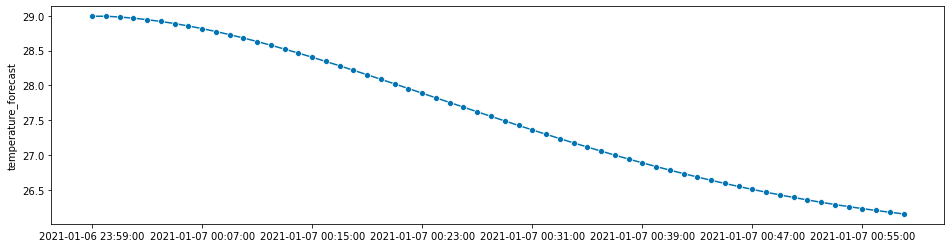

In [27]:
plot_series(pdf_series)

予測結果を表すグラフが表示されているはずである。

今回は単純な例だが、このように一定の規則でグループ化した時系列データに対して分析する処理を並列処理で実装できる。

# ストリーム処理で扱えるか？

残念ながら、2021/10時点のDelta Sharingはストリームデータとしての読み込みに対応していない。